In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
import os
import pc
import ecg_plot

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy import optimize
from scipy.io import loadmat
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import concatenate, GlobalAveragePooling1D
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Add, GRU, Flatten
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPool1D, ZeroPadding1D, LSTM, Bidirectional

### Data Prep

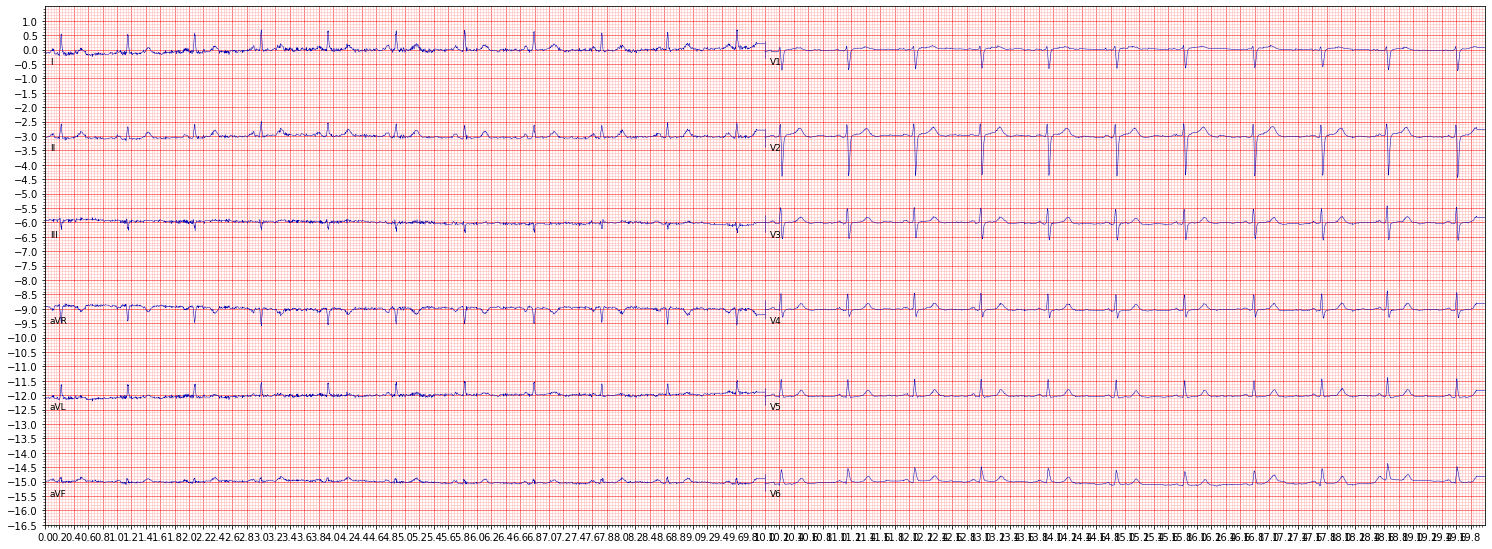

In [3]:
def plot_ecg(path):
    ecg_data = pc.load_challenge_data(path)
    ecg_plot.plot(ecg_data[0]/1000, sample_rate=500, title='')
    ecg_plot.show()
    
plot_ecg("WFDB/HR00001.mat")

In [4]:
gender, age, labels, ecg_filenames = pc.import_key_data("WFDB/")

In [5]:
ecg_filenames = np.asarray(ecg_filenames)

In [6]:
SNOMED_scored = pd.read_csv("SNOMED_mappings_scored.csv", sep=";")
SNOMED_unscored = pd.read_csv("SNOMED_mappings_unscored.csv", sep=";")
df_labels = pc.make_undefined_class(labels,SNOMED_unscored)

In [7]:
y , snomed_classes = pc.onehot_encode(df_labels)

The classes we will look at are encoded as SNOMED CT codes:
['10370003' '111975006' '164889003' '164890007' '164909002' '164917005'
 '164934002' '164947007' '251146004' '270492004' '284470004' '39732003'
 '426177001' '426783006' '427084000' '427393009' '445118002' '47665007'
 '59931005' '63593006' '698252002' '713426002' '713427006'
 'undefined class']
classes: 23


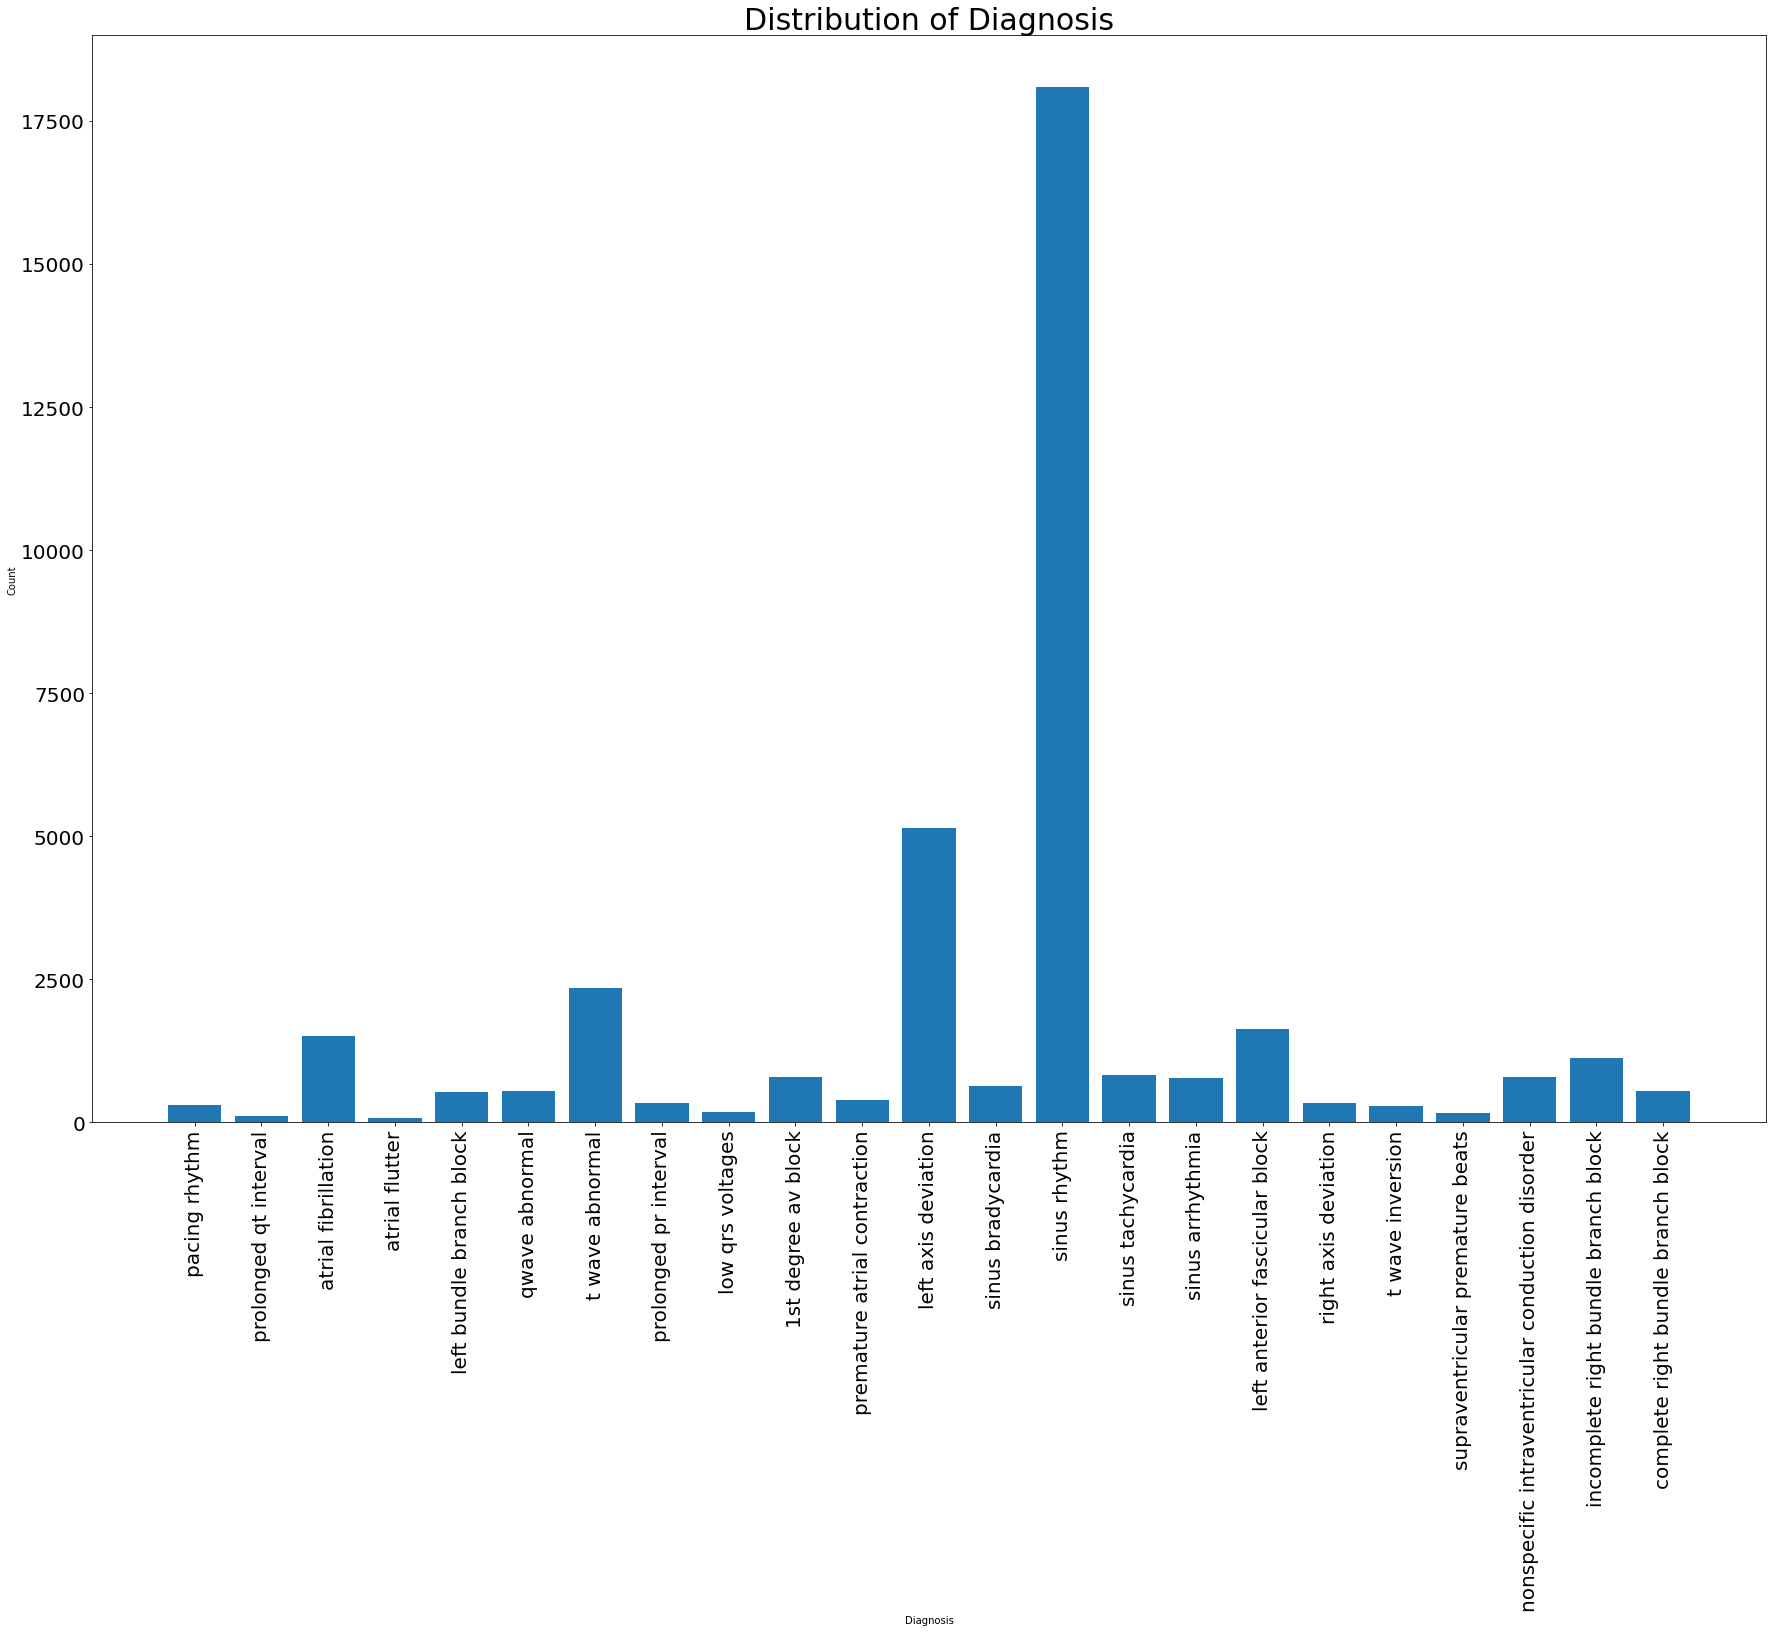

In [8]:
pc.plot_classes(snomed_classes, SNOMED_scored,y)

In [9]:
y_all_comb = pc.get_labels_for_all_combinations(y)
folds = pc.split_data(labels, y_all_comb)
order_array = folds[0][0]

Training split: 19653
Validation split: 2184


### Utility Functions

In [10]:
def shuffle_batch_generator(batch_size, gen_x,gen_y): 
    np.random.shuffle(order_array)
    batch_features = np.zeros((batch_size,5000, 12))
    batch_labels = np.zeros((batch_size,snomed_classes.shape[0])) 
    while True:
        for i in range(batch_size):

            batch_features[i] = next(gen_x)
            batch_labels[i] = next(gen_y)
            
        yield batch_features, batch_labels

def generate_y_shuffle(y_train):
    while True:
        for i in order_array:
            y_shuffled = y_train[i]
            yield y_shuffled


def generate_X_shuffle(X_train):
    while True:
        for i in order_array:
                #if filepath.endswith(".mat"):
                    data, header_data = pc.load_challenge_data(X_train[i])
                    X_train_new = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
                    X_train_new = X_train_new.reshape(5000,12)
                    yield X_train_new

In [11]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_AUC', factor=0.1, patience=3, verbose=1, mode='max',
    min_delta=0.0001, cooldown=0, min_lr=0
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', mode='max', verbose=1, patience=3)

In [12]:
batchsize = 16

### Inception Model

In [13]:
def inception_block(prev_layer):
    
    conv1=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv1=BatchNormalization()(conv1)
    conv1=Activation('relu')(conv1)
    
    conv3=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv3=BatchNormalization()(conv3)
    conv3=Activation('relu')(conv3)
    conv3=Conv1D(filters = 64, kernel_size = 3, padding = 'same')(conv3)
    conv3=BatchNormalization()(conv3)
    conv3=Activation('relu')(conv3)
    
    conv5=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv5=BatchNormalization()(conv5)
    conv5=Activation('relu')(conv5)
    conv5=Conv1D(filters = 64, kernel_size = 5, padding = 'same')(conv5)
    conv5=BatchNormalization()(conv5)
    conv5=Activation('relu')(conv5)
    
    pool= MaxPool1D(pool_size=3, strides=1, padding='same')(prev_layer)
    convmax=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(pool)
    convmax=BatchNormalization()(convmax)
    convmax=Activation('relu')(convmax)
    
    layer_out = concatenate([conv1, conv3, conv5, convmax], axis=1)
    
    return layer_out

def inception_model(input_shape):
    X_input=Input(input_shape)
    
    X = ZeroPadding1D(3)(X_input)
    
    X = Conv1D(filters = 64, kernel_size = 7, padding = 'same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool1D(pool_size=3, strides=2, padding='same')(X)
    
    X = Conv1D(filters = 64, kernel_size = 1, padding = 'same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = inception_block(X)
    X = inception_block(X)
    
    X = MaxPool1D(pool_size=7, strides=2, padding='same')(X)
    
    X = GlobalMaxPooling1D()(X)
    X = Dense(23,activation='sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = X, name='Inception')
    
    return model

In [14]:
inception_model = inception_model(input_shape = (5000,12))
inception_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), \
                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), \
                        metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),\
                                 tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [15]:
inception_model.summary()

Model: "Inception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5000, 12)]   0                                            
__________________________________________________________________________________________________
zero_padding1d (ZeroPadding1D)  (None, 5006, 12)     0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 5006, 64)     5440        zero_padding1d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 5006, 64)     256         conv1d[0][0]                     
__________________________________________________________________________________________

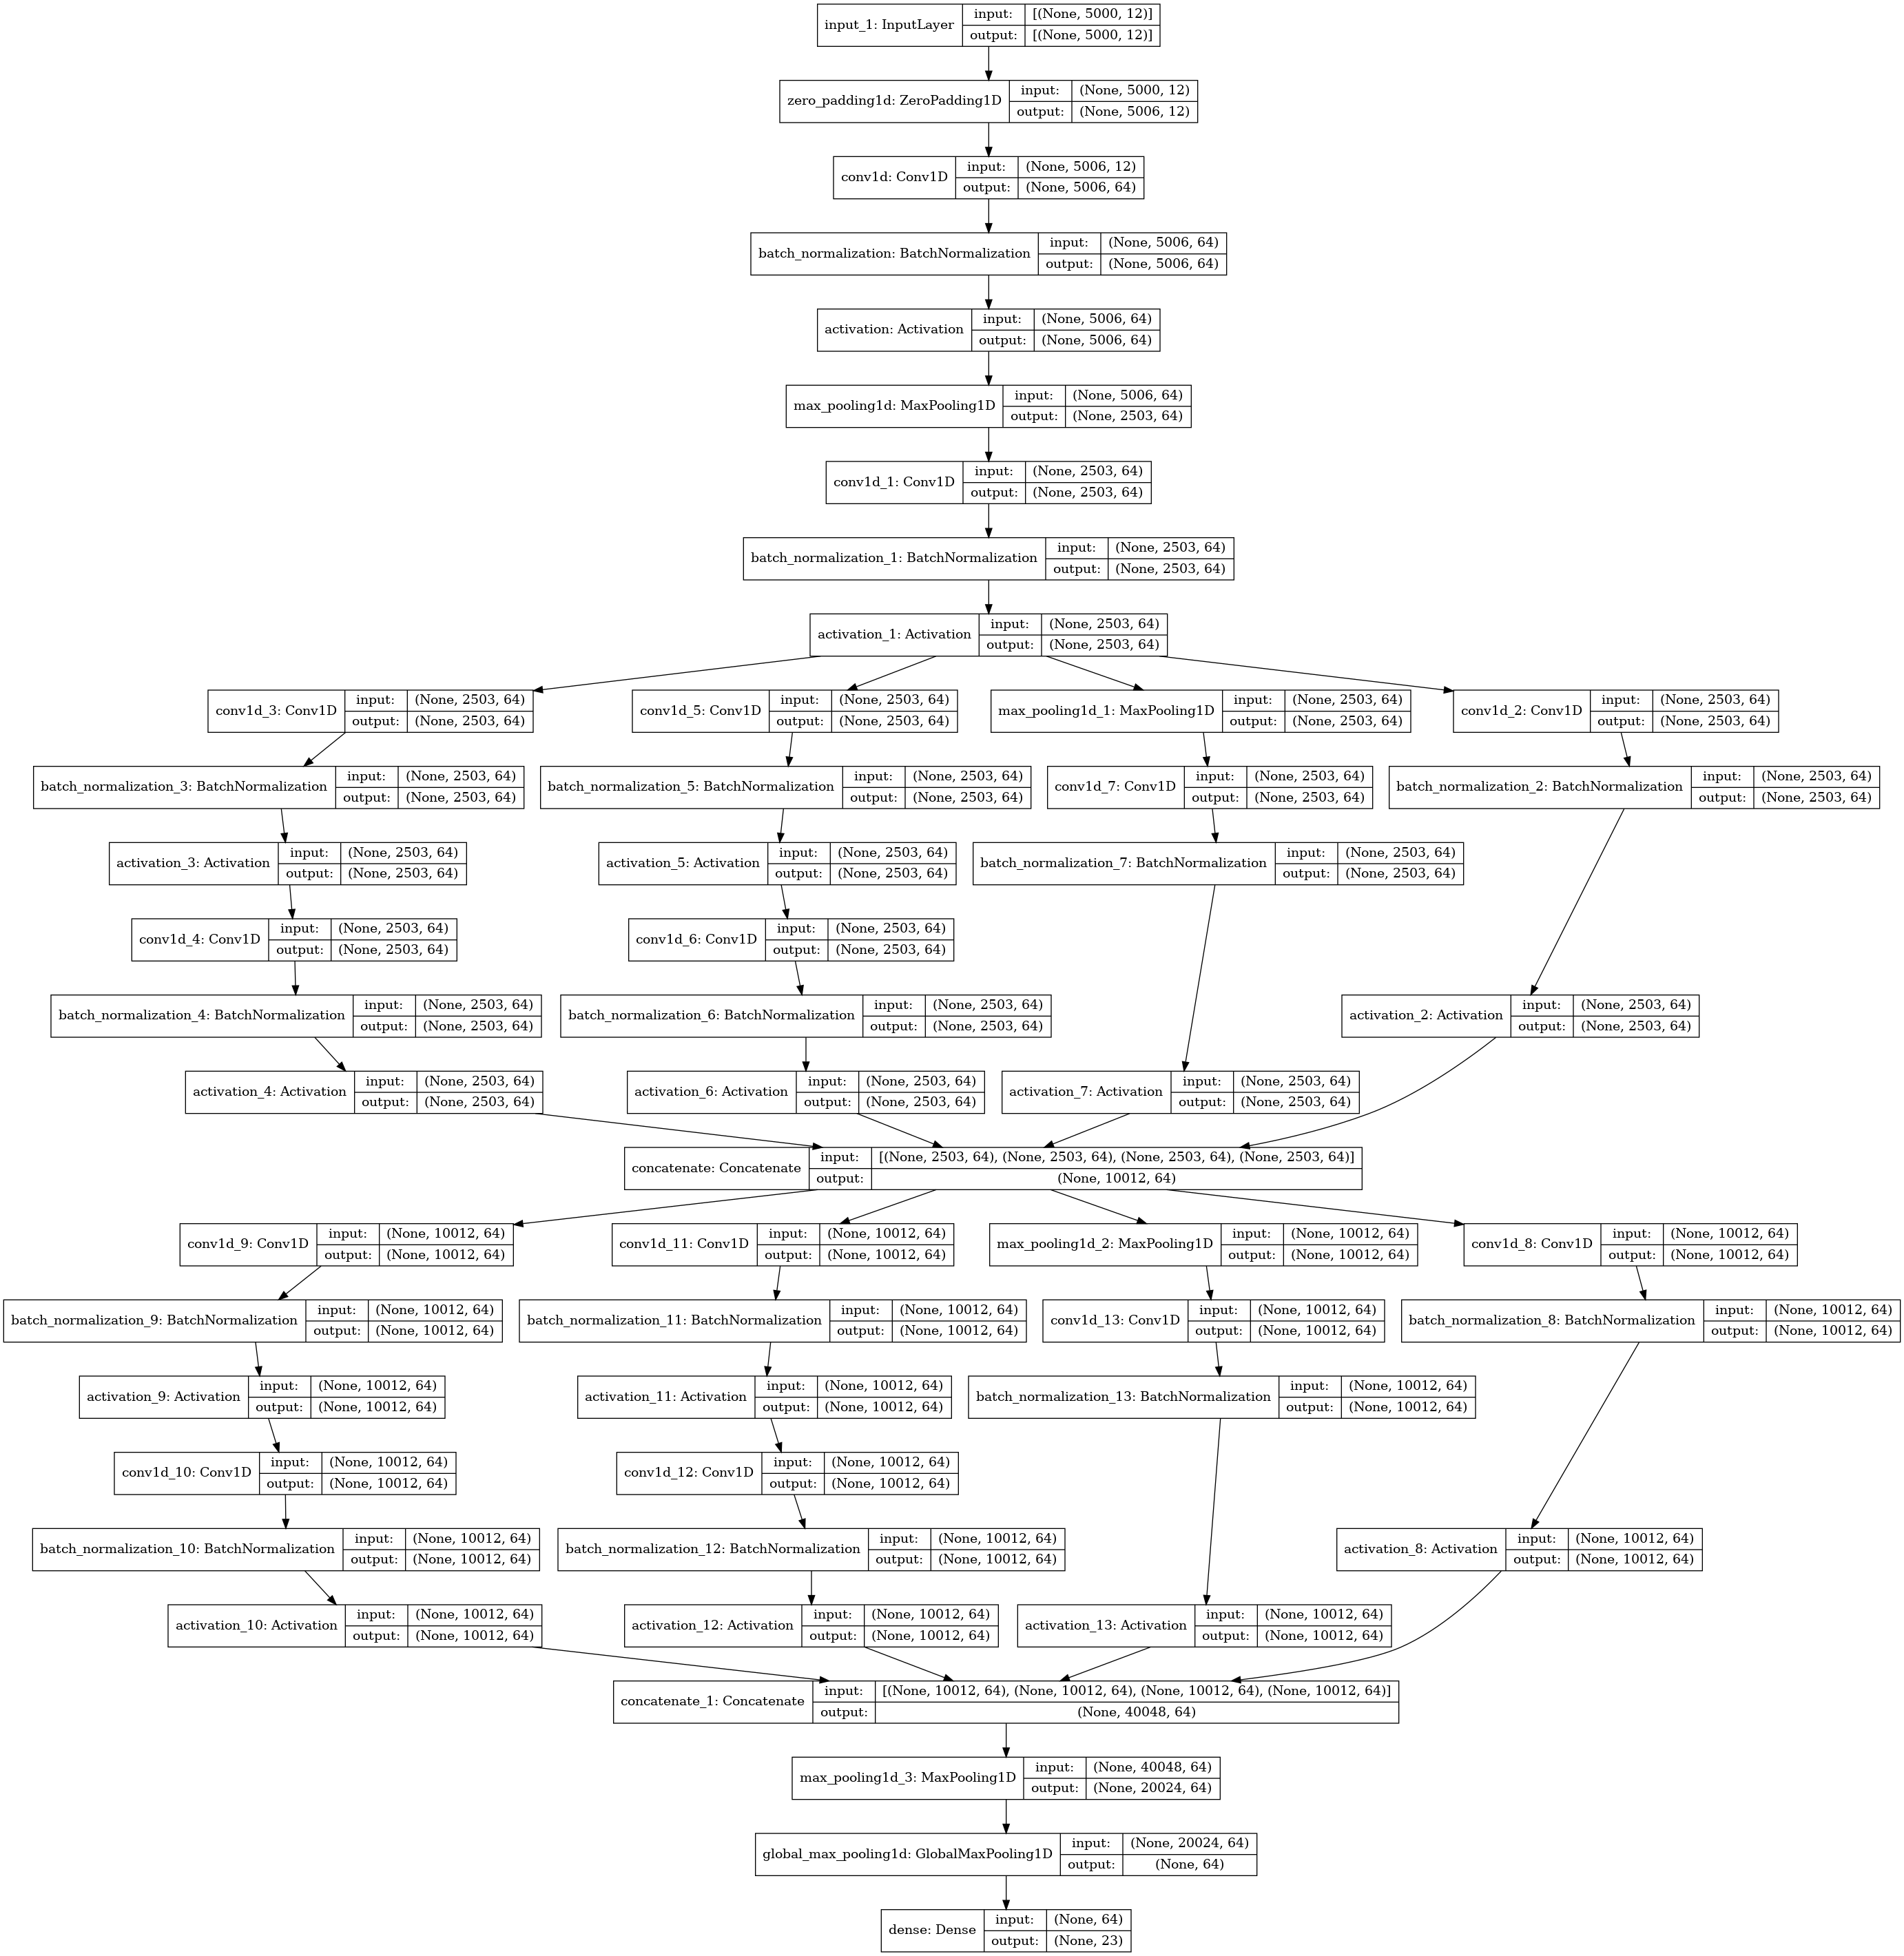

In [16]:
plot_model(inception_model, show_shapes=True)

In [17]:
inception_model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), \
                                            gen_y=generate_y_shuffle(y)), epochs=100, \
                  steps_per_epoch=(len(order_array)/(batchsize*10)), \
                  validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]))

Epoch 1/100
122/122 [==============================] - 13s 75ms/step - loss: 1.0184 - accuracy: 0.8577 - Recall: 0.5237 - Precision: 0.3309 - AUC: 0.4820 - val_loss: 0.3316 - val_accuracy: 0.8881 - val_Recall: 0.1237 - val_Precision: 0.1665 - val_AUC: 0.5365
Epoch 2/100
122/122 [==============================] - 8s 67ms/step - loss: 0.1907 - accuracy: 0.9500 - Recall: 0.5038 - Precision: 0.7364 - AUC: 0.5543 - val_loss: 0.1896 - val_accuracy: 0.9494 - val_Recall: 0.5503 - val_Precision: 0.7090 - val_AUC: 0.5634
Epoch 3/100
122/122 [==============================] - 8s 69ms/step - loss: 0.1841 - accuracy: 0.9523 - Recall: 0.4994 - Precision: 0.7793 - AUC: 0.5623 - val_loss: 0.1987 - val_accuracy: 0.9511 - val_Recall: 0.4902 - val_Precision: 0.7731 - val_AUC: 0.5744
Epoch 4/100
122/122 [==============================] - 8s 68ms/step - loss: 0.1706 - accuracy: 0.9522 - Recall: 0.5106 - Precision: 0.7571 - AUC: 0.5793 - val_loss: 0.1737 - val_accuracy: 0.9537 - val_Recall: 0.5056 - val_Pre

Epoch 33/100
122/122 [==============================] - 8s 64ms/step - loss: 0.1203 - accuracy: 0.9598 - Recall: 0.5817 - Precision: 0.8314 - AUC: 0.7811 - val_loss: 0.1237 - val_accuracy: 0.9583 - val_Recall: 0.5891 - val_Precision: 0.8014 - val_AUC: 0.8191
Epoch 34/100
122/122 [==============================] - 8s 64ms/step - loss: 0.1176 - accuracy: 0.9614 - Recall: 0.6059 - Precision: 0.8261 - AUC: 0.7886 - val_loss: 0.1165 - val_accuracy: 0.9613 - val_Recall: 0.5931 - val_Precision: 0.8437 - val_AUC: 0.8165
Epoch 35/100
122/122 [==============================] - 8s 64ms/step - loss: 0.1174 - accuracy: 0.9606 - Recall: 0.5880 - Precision: 0.8360 - AUC: 0.7983 - val_loss: 0.1160 - val_accuracy: 0.9612 - val_Recall: 0.5654 - val_Precision: 0.8706 - val_AUC: 0.8325
Epoch 36/100
122/122 [==============================] - 8s 64ms/step - loss: 0.1026 - accuracy: 0.9664 - Recall: 0.6420 - Precision: 0.8544 - AUC: 0.8119 - val_loss: 0.1213 - val_accuracy: 0.9589 - val_Recall: 0.5934 - val_

Epoch 65/100
122/122 [==============================] - 8s 64ms/step - loss: 0.1019 - accuracy: 0.9644 - Recall: 0.6393 - Precision: 0.8462 - AUC: 0.8423 - val_loss: 0.1088 - val_accuracy: 0.9632 - val_Recall: 0.6152 - val_Precision: 0.8513 - val_AUC: 0.8690
Epoch 66/100
122/122 [==============================] - 8s 64ms/step - loss: 0.0950 - accuracy: 0.9681 - Recall: 0.6672 - Precision: 0.8639 - AUC: 0.8596 - val_loss: 0.1114 - val_accuracy: 0.9620 - val_Recall: 0.6215 - val_Precision: 0.8278 - val_AUC: 0.8654
Epoch 67/100
122/122 [==============================] - 8s 64ms/step - loss: 0.1001 - accuracy: 0.9656 - Recall: 0.6405 - Precision: 0.8549 - AUC: 0.8505 - val_loss: 0.1085 - val_accuracy: 0.9628 - val_Recall: 0.6239 - val_Precision: 0.8370 - val_AUC: 0.8725
Epoch 68/100
122/122 [==============================] - 8s 64ms/step - loss: 0.1048 - accuracy: 0.9643 - Recall: 0.6423 - Precision: 0.8544 - AUC: 0.8320 - val_loss: 0.1093 - val_accuracy: 0.9631 - val_Recall: 0.6617 - val_

Epoch 97/100
122/122 [==============================] - 8s 64ms/step - loss: 0.0926 - accuracy: 0.9676 - Recall: 0.6823 - Precision: 0.8469 - AUC: 0.8812 - val_loss: 0.1036 - val_accuracy: 0.9647 - val_Recall: 0.6295 - val_Precision: 0.8623 - val_AUC: 0.8834
Epoch 98/100
122/122 [==============================] - 8s 64ms/step - loss: 0.0972 - accuracy: 0.9657 - Recall: 0.6671 - Precision: 0.8535 - AUC: 0.8577 - val_loss: 0.1024 - val_accuracy: 0.9650 - val_Recall: 0.6742 - val_Precision: 0.8260 - val_AUC: 0.8938
Epoch 99/100
122/122 [==============================] - 8s 64ms/step - loss: 0.0990 - accuracy: 0.9650 - Recall: 0.6565 - Precision: 0.8448 - AUC: 0.8691 - val_loss: 0.1027 - val_accuracy: 0.9639 - val_Recall: 0.6410 - val_Precision: 0.8394 - val_AUC: 0.8944
Epoch 100/100
122/122 [==============================] - 8s 64ms/step - loss: 0.0924 - accuracy: 0.9684 - Recall: 0.6709 - Precision: 0.8684 - AUC: 0.8454 - val_loss: 0.1027 - val_accuracy: 0.9645 - val_Recall: 0.6782 - val

Text(0, 0.5, 'Accuracy')

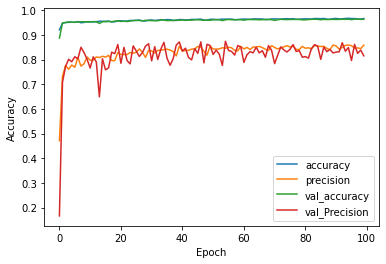

In [18]:
plt.plot(inception_model.history.history['accuracy'])
plt.plot(inception_model.history.history['Precision'])
plt.plot(inception_model.history.history['val_accuracy'])
plt.plot(inception_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

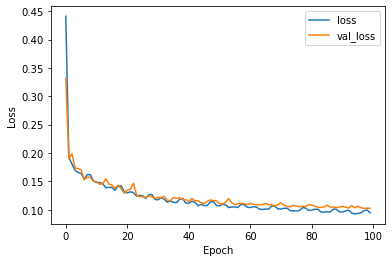

In [19]:
plt.plot(inception_model.history.history['loss'])
plt.plot(inception_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

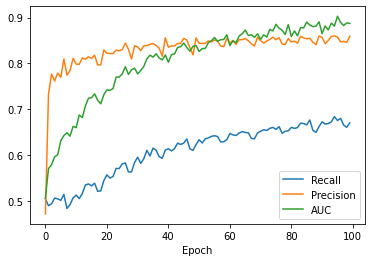

In [20]:
plt.plot(inception_model.history.history['Recall'])
plt.plot(inception_model.history.history['Precision'])
plt.plot(inception_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [21]:
inception_model.save('inception_model.h5')

### Conv1D-Stack

In [22]:
model_conv1d = Sequential()

model_conv1d.add(Conv1D(filters=6, kernel_size=3, padding='same', input_shape=(5000,12)))
model_conv1d.add(BatchNormalization())
model_conv1d.add(Activation('relu'))
model_conv1d.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

model_conv1d.add(Conv1D(filters=16, strides=1, kernel_size=5))
model_conv1d.add(BatchNormalization())
model_conv1d.add(Activation('relu'))
model_conv1d.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

model_conv1d.add(Flatten())

model_conv1d.add(Dense(64, activation='relu'))
model_conv1d.add(Dropout(0.25))
model_conv1d.add(Dense(32, activation='relu'))
model_conv1d.add(Dropout(0.25))
model_conv1d.add(Dense(23, activation='sigmoid'))

In [23]:
model_conv1d.compile(loss = tf.keras.losses.BinaryCrossentropy(), \
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), \
                     metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5), tf.keras.metrics.Recall(name='Recall'), \
                              tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [24]:
model_conv1d.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 5000, 6)           222       
_________________________________________________________________
batch_normalization_14 (Batc (None, 5000, 6)           24        
_________________________________________________________________
activation_14 (Activation)   (None, 5000, 6)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 2500, 6)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 2496, 16)          496       
_________________________________________________________________
batch_normalization_15 (Batc (None, 2496, 16)          64        
_________________________________________________________________
activation_15 (Activation)   (None, 2496, 16)          0

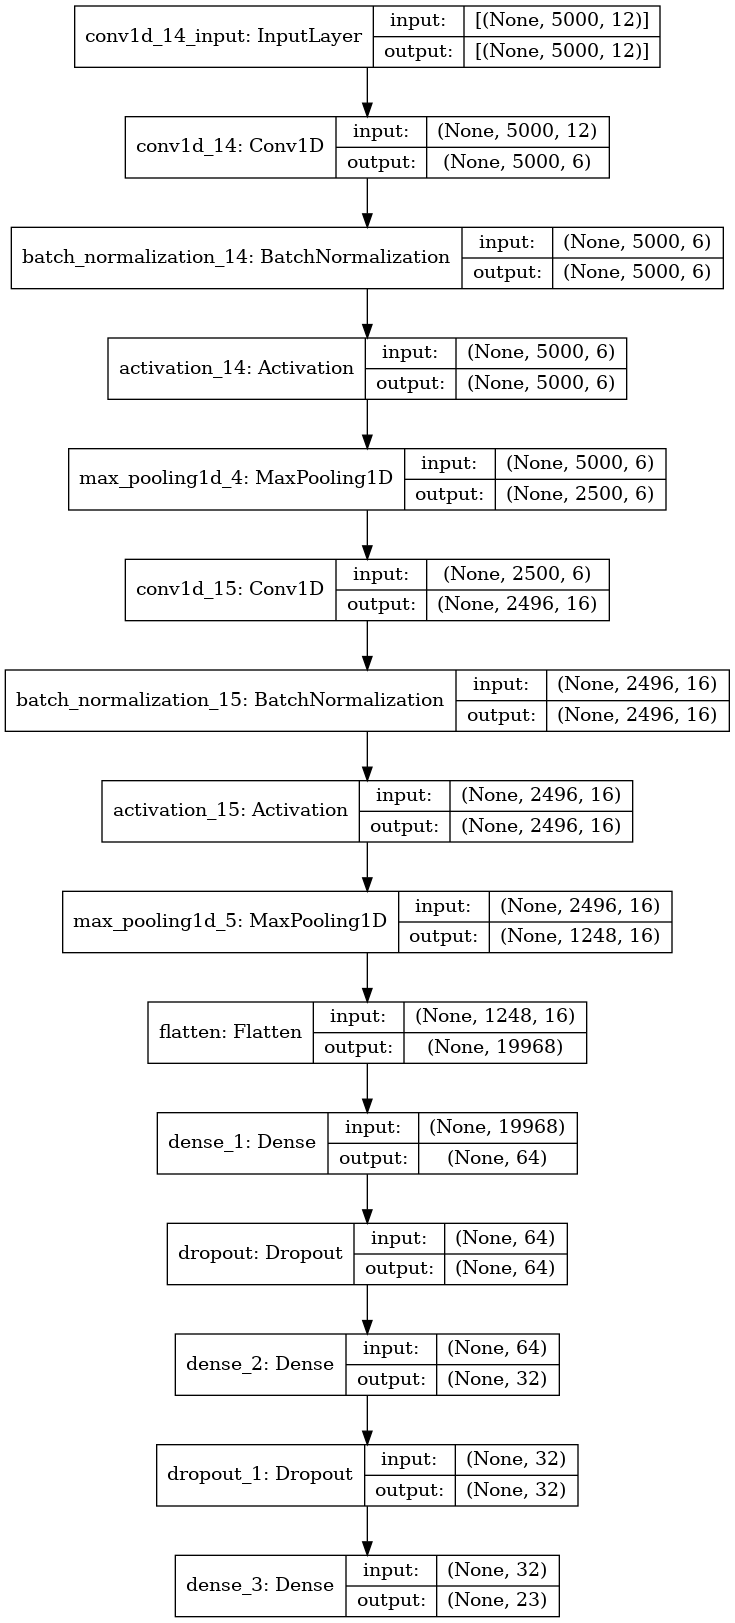

In [25]:
plot_model(model_conv1d, show_shapes=True)

In [26]:
model_conv1d.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), \
                                            gen_y=generate_y_shuffle(y)), epochs=100, \
                  steps_per_epoch=(len(order_array)/(batchsize*10)), \
                  validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]))

Epoch 1/100
122/122 [==============================] - 3s 15ms/step - loss: 0.4627 - accuracy: 0.8212 - Recall: 0.5248 - Precision: 0.2304 - AUC: 0.4981 - val_loss: 0.2107 - val_accuracy: 0.9541 - val_Recall: 0.4878 - val_Precision: 0.8276 - val_AUC: 0.5586
Epoch 2/100
122/122 [==============================] - 1s 12ms/step - loss: 0.2224 - accuracy: 0.9421 - Recall: 0.4978 - Precision: 0.6503 - AUC: 0.5511 - val_loss: 0.1571 - val_accuracy: 0.9537 - val_Recall: 0.4814 - val_Precision: 0.8288 - val_AUC: 0.6266
Epoch 3/100
122/122 [==============================] - 1s 12ms/step - loss: 0.2033 - accuracy: 0.9495 - Recall: 0.4985 - Precision: 0.7334 - AUC: 0.5310 - val_loss: 0.1663 - val_accuracy: 0.9537 - val_Recall: 0.4816 - val_Precision: 0.8285 - val_AUC: 0.6498
Epoch 4/100
122/122 [==============================] - 1s 11ms/step - loss: 0.1920 - accuracy: 0.9500 - Recall: 0.4878 - Precision: 0.7472 - AUC: 0.5540 - val_loss: 0.1545 - val_accuracy: 0.9537 - val_Recall: 0.4814 - val_Prec

Epoch 33/100
122/122 [==============================] - 1s 12ms/step - loss: 0.1405 - accuracy: 0.9577 - Recall: 0.5541 - Precision: 0.8212 - AUC: 0.6634 - val_loss: 0.1405 - val_accuracy: 0.9560 - val_Recall: 0.5221 - val_Precision: 0.8262 - val_AUC: 0.7228
Epoch 34/100
122/122 [==============================] - 1s 12ms/step - loss: 0.1404 - accuracy: 0.9567 - Recall: 0.5438 - Precision: 0.8068 - AUC: 0.6405 - val_loss: 0.1389 - val_accuracy: 0.9560 - val_Recall: 0.5197 - val_Precision: 0.8290 - val_AUC: 0.7249
Epoch 35/100
122/122 [==============================] - 1s 12ms/step - loss: 0.1447 - accuracy: 0.9555 - Recall: 0.5415 - Precision: 0.8093 - AUC: 0.6458 - val_loss: 0.1364 - val_accuracy: 0.9576 - val_Recall: 0.5521 - val_Precision: 0.8235 - val_AUC: 0.7286
Epoch 36/100
122/122 [==============================] - 1s 12ms/step - loss: 0.1408 - accuracy: 0.9585 - Recall: 0.5675 - Precision: 0.8164 - AUC: 0.6650 - val_loss: 0.1368 - val_accuracy: 0.9572 - val_Recall: 0.5444 - val_

Epoch 65/100
122/122 [==============================] - 1s 12ms/step - loss: 0.1449 - accuracy: 0.9541 - Recall: 0.5298 - Precision: 0.8150 - AUC: 0.6811 - val_loss: 0.1347 - val_accuracy: 0.9583 - val_Recall: 0.5779 - val_Precision: 0.8099 - val_AUC: 0.7390
Epoch 66/100
122/122 [==============================] - 1s 12ms/step - loss: 0.1358 - accuracy: 0.9582 - Recall: 0.5602 - Precision: 0.8262 - AUC: 0.7120 - val_loss: 0.1339 - val_accuracy: 0.9585 - val_Recall: 0.5753 - val_Precision: 0.8156 - val_AUC: 0.7564
Epoch 67/100
122/122 [==============================] - 1s 12ms/step - loss: 0.1264 - accuracy: 0.9606 - Recall: 0.5804 - Precision: 0.8230 - AUC: 0.7113 - val_loss: 0.1360 - val_accuracy: 0.9579 - val_Recall: 0.6053 - val_Precision: 0.7829 - val_AUC: 0.7359
Epoch 68/100
122/122 [==============================] - 1s 12ms/step - loss: 0.1294 - accuracy: 0.9614 - Recall: 0.5831 - Precision: 0.8500 - AUC: 0.7189 - val_loss: 0.1400 - val_accuracy: 0.9580 - val_Recall: 0.5649 - val_

Epoch 97/100
122/122 [==============================] - 1s 12ms/step - loss: 0.1251 - accuracy: 0.9610 - Recall: 0.5734 - Precision: 0.8372 - AUC: 0.7173 - val_loss: 0.1360 - val_accuracy: 0.9574 - val_Recall: 0.6074 - val_Precision: 0.7753 - val_AUC: 0.7416
Epoch 98/100
122/122 [==============================] - 1s 12ms/step - loss: 0.1268 - accuracy: 0.9605 - Recall: 0.5654 - Precision: 0.8537 - AUC: 0.7242 - val_loss: 0.1364 - val_accuracy: 0.9578 - val_Recall: 0.5819 - val_Precision: 0.7997 - val_AUC: 0.7245
Epoch 99/100
122/122 [==============================] - 1s 12ms/step - loss: 0.1298 - accuracy: 0.9606 - Recall: 0.5771 - Precision: 0.8353 - AUC: 0.7276 - val_loss: 0.1350 - val_accuracy: 0.9586 - val_Recall: 0.5785 - val_Precision: 0.8146 - val_AUC: 0.7327
Epoch 100/100
122/122 [==============================] - 1s 12ms/step - loss: 0.1310 - accuracy: 0.9585 - Recall: 0.5525 - Precision: 0.8440 - AUC: 0.7577 - val_loss: 0.1331 - val_accuracy: 0.9588 - val_Recall: 0.5721 - val

Text(0, 0.5, 'Accuracy')

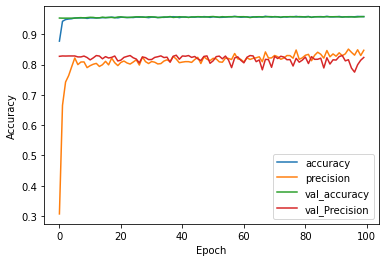

In [27]:
plt.plot(model_conv1d.history.history['accuracy'])
plt.plot(model_conv1d.history.history['Precision'])
plt.plot(model_conv1d.history.history['val_accuracy'])
plt.plot(model_conv1d.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

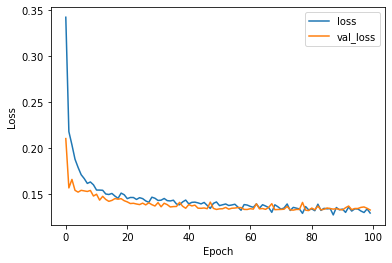

In [28]:
plt.plot(model_conv1d.history.history['loss'])
plt.plot(model_conv1d.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

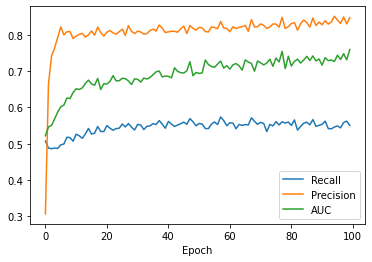

In [29]:
plt.plot(model_conv1d.history.history['Recall'])
plt.plot(model_conv1d.history.history['Precision'])
plt.plot(model_conv1d.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [30]:
model_conv1d.save('conv1dstack.h5')

### GRU Model

In [31]:
lstm_model = Sequential()
lstm_model.add(tf.keras.layers.InputLayer((5000,12)))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(LSTM(32, return_sequences = True))
lstm_model.add(Flatten())
lstm_model.add(Dense(128, activation = 'relu'))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(23, activation = 'sigmoid'))

In [32]:
lstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), \
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),\
                   metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),\
                            tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [33]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5000, 64)          19712     
_________________________________________________________________
lstm_1 (LSTM)                (None, 5000, 32)          12416     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160000)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               20480128  
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 23)                2967      
Total params: 20,515,223
Trainable params: 20,515,223
Non-trainable params: 0
__________________________________________

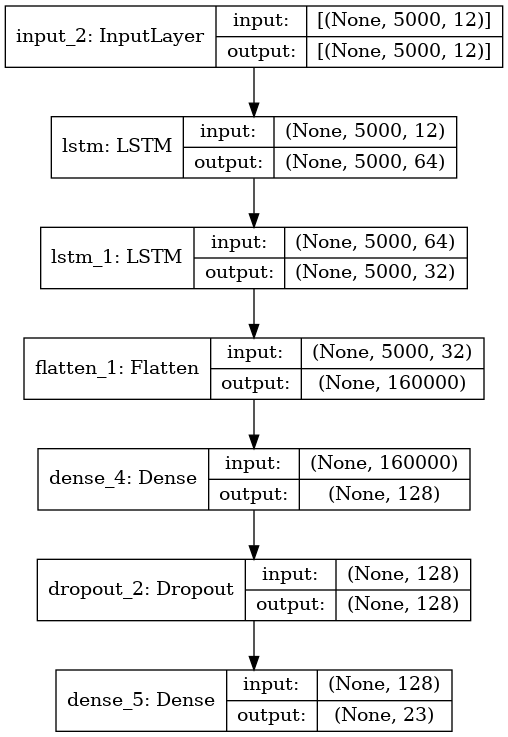

In [34]:
plot_model(lstm_model, show_shapes = True)

In [35]:
lstm_model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames),\
                                         gen_y=generate_y_shuffle(y)), epochs=50, \
               steps_per_epoch=(len(order_array)/(batchsize*10)), \
               validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]), \
                  callbacks=[reduce_lr,early_stop])

Epoch 1/50
122/122 [==============================] - 33s 257ms/step - loss: 0.4323 - accuracy: 0.8890 - Recall: 0.5317 - Precision: 0.3819 - AUC: 0.5450 - val_loss: 0.2036 - val_accuracy: 0.9548 - val_Recall: 0.4894 - val_Precision: 0.8402 - val_AUC: 0.6333
Epoch 2/50
122/122 [==============================] - 31s 251ms/step - loss: 0.1814 - accuracy: 0.9475 - Recall: 0.5343 - Precision: 0.6970 - AUC: 0.6405 - val_loss: 0.1403 - val_accuracy: 0.9555 - val_Recall: 0.4811 - val_Precision: 0.8639 - val_AUC: 0.7410
Epoch 3/50
122/122 [==============================] - 31s 252ms/step - loss: 0.1610 - accuracy: 0.9525 - Recall: 0.5375 - Precision: 0.7652 - AUC: 0.6698 - val_loss: 0.1330 - val_accuracy: 0.9583 - val_Recall: 0.5758 - val_Precision: 0.8124 - val_AUC: 0.7588
Epoch 4/50
122/122 [==============================] - 31s 252ms/step - loss: 0.1546 - accuracy: 0.9538 - Recall: 0.5507 - Precision: 0.7721 - AUC: 0.6805 - val_loss: 0.1305 - val_accuracy: 0.9585 - val_Recall: 0.5633 - val_

Text(0, 0.5, 'Accuracy')

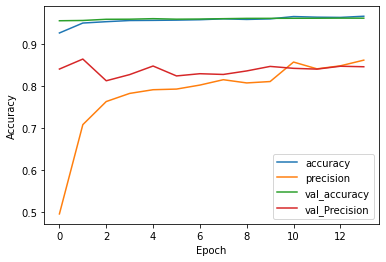

In [36]:
plt.plot(lstm_model.history.history['accuracy'])
plt.plot(lstm_model.history.history['Precision'])
plt.plot(lstm_model.history.history['val_accuracy'])
plt.plot(lstm_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

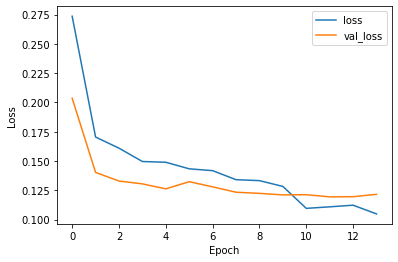

In [37]:
plt.plot(lstm_model.history.history['loss'])
plt.plot(lstm_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

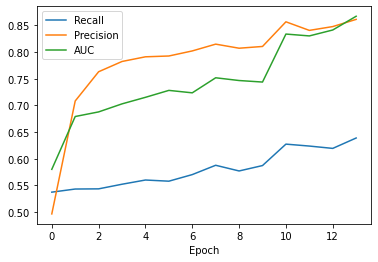

In [38]:
plt.plot(lstm_model.history.history['Recall'])
plt.plot(lstm_model.history.history['Precision'])
plt.plot(lstm_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [39]:
lstm_model.save('lstmmodel.h5')

In [40]:
gru_model = Sequential()
gru_model.add(tf.keras.layers.InputLayer((5000,12)))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(GRU(32, return_sequences = True))
gru_model.add(Flatten())
gru_model.add(Dense(128, activation = 'relu'))
gru_model.add(Dropout(0.3))
gru_model.add(Dense(23, activation = 'sigmoid'))

In [41]:
gru_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), \
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),\
                   metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),\
                            tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [42]:
gru_model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames),\
                                         gen_y=generate_y_shuffle(y)), epochs=50, \
               steps_per_epoch=(len(order_array)/(batchsize*10)), \
               validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]))

Epoch 1/50
122/122 [==============================] - 32s 246ms/step - loss: 0.9154 - accuracy: 0.8092 - Recall: 0.5473 - Precision: 0.2156 - AUC: 0.5343 - val_loss: 0.2109 - val_accuracy: 0.9501 - val_Recall: 0.5593 - val_Precision: 0.7126 - val_AUC: 0.5849
Epoch 2/50
122/122 [==============================] - 29s 240ms/step - loss: 0.2702 - accuracy: 0.9181 - Recall: 0.5277 - Precision: 0.4682 - AUC: 0.5704 - val_loss: 0.1709 - val_accuracy: 0.9537 - val_Recall: 0.5037 - val_Precision: 0.8046 - val_AUC: 0.6210
Epoch 3/50
122/122 [==============================] - 29s 240ms/step - loss: 0.2036 - accuracy: 0.9396 - Recall: 0.5222 - Precision: 0.6131 - AUC: 0.6008 - val_loss: 0.1700 - val_accuracy: 0.9543 - val_Recall: 0.4949 - val_Precision: 0.8235 - val_AUC: 0.6556
Epoch 4/50
122/122 [==============================] - 30s 242ms/step - loss: 0.1906 - accuracy: 0.9480 - Recall: 0.5311 - Precision: 0.6895 - AUC: 0.6092 - val_loss: 0.1720 - val_accuracy: 0.9550 - val_Recall: 0.5763 - val_

122/122 [==============================] - 30s 243ms/step - loss: 0.1410 - accuracy: 0.9586 - Recall: 0.5810 - Precision: 0.8171 - AUC: 0.6980 - val_loss: 0.1414 - val_accuracy: 0.9566 - val_Recall: 0.5285 - val_Precision: 0.8303 - val_AUC: 0.7053
Epoch 33/50
122/122 [==============================] - 30s 243ms/step - loss: 0.1406 - accuracy: 0.9576 - Recall: 0.5918 - Precision: 0.7942 - AUC: 0.7033 - val_loss: 0.1344 - val_accuracy: 0.9575 - val_Recall: 0.5444 - val_Precision: 0.8287 - val_AUC: 0.7320
Epoch 34/50
122/122 [==============================] - 30s 242ms/step - loss: 0.1332 - accuracy: 0.9605 - Recall: 0.5882 - Precision: 0.8206 - AUC: 0.6974 - val_loss: 0.1358 - val_accuracy: 0.9576 - val_Recall: 0.5476 - val_Precision: 0.8282 - val_AUC: 0.7240
Epoch 35/50
122/122 [==============================] - 30s 243ms/step - loss: 0.1410 - accuracy: 0.9575 - Recall: 0.5736 - Precision: 0.8142 - AUC: 0.7343 - val_loss: 0.1350 - val_accuracy: 0.9580 - val_Recall: 0.5790 - val_Precisio

In [43]:
bilstm_model = Sequential()
bilstm_model.add(tf.keras.layers.InputLayer((5000,12)))
bilstm_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bilstm_model.add(Bidirectional(LSTM(32, return_sequences = True)))
bilstm_model.add(GlobalAveragePooling1D())
bilstm_model.add(Dense(128, activation = 'relu'))
bilstm_model.add(Dropout(0.3))
bilstm_model.add(Dense(23, activation = 'sigmoid'))

In [44]:
bilstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), \
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),\
                   metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),\
                            tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [45]:
bilstm_model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames),\
                                         gen_y=generate_y_shuffle(y)), epochs=50, \
               steps_per_epoch=(len(order_array)/(batchsize*10)), \
               validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]), \
                  callbacks=[reduce_lr,early_stop])

Epoch 1/50
122/122 [==============================] - 64s 498ms/step - loss: 0.3424 - accuracy: 0.8819 - Recall: 0.5390 - Precision: 0.3807 - AUC: 0.4992 - val_loss: 0.1636 - val_accuracy: 0.9537 - val_Recall: 0.4814 - val_Precision: 0.8288 - val_AUC: 0.5631
Epoch 2/50
122/122 [==============================] - 60s 490ms/step - loss: 0.1699 - accuracy: 0.9542 - Recall: 0.4975 - Precision: 0.8196 - AUC: 0.5137 - val_loss: 0.1589 - val_accuracy: 0.9537 - val_Recall: 0.4814 - val_Precision: 0.8288 - val_AUC: 0.6291
Epoch 3/50
122/122 [==============================] - 60s 490ms/step - loss: 0.1660 - accuracy: 0.9541 - Recall: 0.4892 - Precision: 0.8192 - AUC: 0.5349 - val_loss: 0.1554 - val_accuracy: 0.9538 - val_Recall: 0.4902 - val_Precision: 0.8209 - val_AUC: 0.6507
Epoch 4/50
122/122 [==============================] - 60s 490ms/step - loss: 0.1604 - accuracy: 0.9538 - Recall: 0.4992 - Precision: 0.8031 - AUC: 0.5648 - val_loss: 0.1542 - val_accuracy: 0.9541 - val_Recall: 0.4968 - val_

122/122 [==============================] - 60s 490ms/step - loss: 0.1297 - accuracy: 0.9590 - Recall: 0.5602 - Precision: 0.8493 - AUC: 0.7601 - val_loss: 0.1227 - val_accuracy: 0.9597 - val_Recall: 0.5689 - val_Precision: 0.8415 - val_AUC: 0.8266
Epoch 33/50
122/122 [==============================] - 60s 491ms/step - loss: 0.1273 - accuracy: 0.9572 - Recall: 0.5386 - Precision: 0.8369 - AUC: 0.7777 - val_loss: 0.1224 - val_accuracy: 0.9595 - val_Recall: 0.5723 - val_Precision: 0.8348 - val_AUC: 0.8182
Epoch 34/50
122/122 [==============================] - 60s 489ms/step - loss: 0.1301 - accuracy: 0.9575 - Recall: 0.5490 - Precision: 0.8277 - AUC: 0.7325 - val_loss: 0.1213 - val_accuracy: 0.9604 - val_Recall: 0.5604 - val_Precision: 0.8632 - val_AUC: 0.8274
Epoch 35/50
122/122 [==============================] - 60s 491ms/step - loss: 0.1267 - accuracy: 0.9577 - Recall: 0.5451 - Precision: 0.8427 - AUC: 0.7855 - val_loss: 0.1204 - val_accuracy: 0.9595 - val_Recall: 0.5420 - val_Precisio

In [46]:
bigru_model = Sequential()
bigru_model.add(tf.keras.layers.InputLayer((5000,12)))
bigru_model.add(Bidirectional(GRU(64, return_sequences=True)))
bigru_model.add(Bidirectional(GRU(32, return_sequences = True)))
bigru_model.add(GlobalAveragePooling1D())
bigru_model.add(Dense(128, activation = 'relu'))
bigru_model.add(Dropout(0.3))
bigru_model.add(Dense(23, activation = 'sigmoid'))

In [47]:
bigru_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), \
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),\
                   metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),\
                            tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [48]:
bigru_model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames),\
                                         gen_y=generate_y_shuffle(y)), epochs=50, \
               steps_per_epoch=(len(order_array)/(batchsize*10)), \
               validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]), \
                  callbacks=[reduce_lr,early_stop])

Epoch 1/50
122/122 [==============================] - 61s 475ms/step - loss: 0.3134 - accuracy: 0.8776 - Recall: 0.4359 - Precision: 0.3788 - AUC: 0.5150 - val_loss: 0.1613 - val_accuracy: 0.9537 - val_Recall: 0.4814 - val_Precision: 0.8288 - val_AUC: 0.5774
Epoch 2/50
122/122 [==============================] - 57s 466ms/step - loss: 0.1697 - accuracy: 0.9543 - Recall: 0.4937 - Precision: 0.8259 - AUC: 0.4932 - val_loss: 0.1583 - val_accuracy: 0.9537 - val_Recall: 0.4814 - val_Precision: 0.8288 - val_AUC: 0.6204
Epoch 3/50
122/122 [==============================] - 57s 467ms/step - loss: 0.1657 - accuracy: 0.9519 - Recall: 0.4824 - Precision: 0.8135 - AUC: 0.5399 - val_loss: 0.1561 - val_accuracy: 0.9543 - val_Recall: 0.5013 - val_Precision: 0.8171 - val_AUC: 0.6549
Epoch 4/50
122/122 [==============================] - 57s 467ms/step - loss: 0.1576 - accuracy: 0.9551 - Recall: 0.5003 - Precision: 0.8225 - AUC: 0.5985 - val_loss: 0.1526 - val_accuracy: 0.9543 - val_Recall: 0.5146 - val_